# Density & Speed Minimal Analysis

Computes 2-hour windowed network density stats, filters streets by speed ratio drops, plots normalized speeds vs mean density, and highlights critical streets on the map.


In [52]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

WINDOW_SECONDS = 7200  # 2 hours

stability = pd.read_csv(Path("../output/stability_timestep.csv"), sep=";").sort_values("time_step").reset_index(drop=True)
data = pd.read_csv(Path("../output/data.csv"), sep=";").sort_values("time_step").reset_index(drop=True)
counts = pd.read_csv(Path("../output/counts.csv"), sep=";").sort_values("time_step").reset_index(drop=True)
speeds = pd.read_csv(Path("../output/street_speeds.csv"), sep=";").sort_values("time_step").reset_index(drop=True)
edges = pd.read_csv(Path("../input/edges_tl.csv"), sep=";")

In [53]:
# 2-hour windowed network density around each stability timestep
rows = []
for _, row in stability.iterrows():
    t = row["time_step"]
    mask = (data["time_step"] > t - WINDOW_SECONDS) & (data["time_step"] <= t)
    window = data.loc[mask, "mean_density_vpk"]
    out = {
        "time_step": t,
        "mean_density_vpk": row["mean_density_vpk"],
        "window_mean_density": window.mean() if not window.empty else pd.NA,
        "window_std_density": window.std(ddof=1) if len(window) > 1 else pd.NA,
        "window_samples": len(window),
    }
    rows.append(out)

window_density = pd.DataFrame(rows)
window_density.head()

time_step  mean_density_vpk  window_mean_density  window_std_density  \
0       7200             0.594             0.580708            0.061858   
1      15900             1.100             1.061250            0.028940   
2      26100             1.540             1.521250            0.035547   
3      42900             1.960             1.980833            0.042006   
4      56700             2.480             2.472917            0.043786   

   window_samples  
0              24  
1              24  
2              24  
3              24  
4              24

In [54]:
# Prepare street subset and speed ratios
street_subset = [c for c in counts.columns if c not in ("datetime", "time_step")]
speed_cols = [c for c in speeds.columns if c not in ("datetime", "time_step")]
maxspeed_map = edges.set_index(edges["id"].astype(str))["maxspeed"].to_dict()

speeds_filled = speeds.copy()
merged = speeds_filled.merge(
    stability[["time_step", "mean_density_vpk"]], on="time_step", how="inner"
)

cutoff_mask_20 = merged["mean_density_vpk"] < 20

keep_streets = []
for col in street_subset:
    ms = maxspeed_map.get(col) / 3.6  # Convert km/h to m/s
    if ms is None or pd.isna(ms) or ms == 0 or col not in speed_cols:
        continue
    ratio = merged[col] / ms
    if (ratio[cutoff_mask_20] < 0.5).any() and (ratio > 0.6).any():
        keep_streets.append(col)

print(
    f"Streets kept (ratio < 0.5 before mean density 20 AND ever > 0.6): {len(keep_streets)} / {len(street_subset)}"
)

Streets kept (ratio < 0.5 before mean density 20 AND ever > 0.6): 484 / 3475


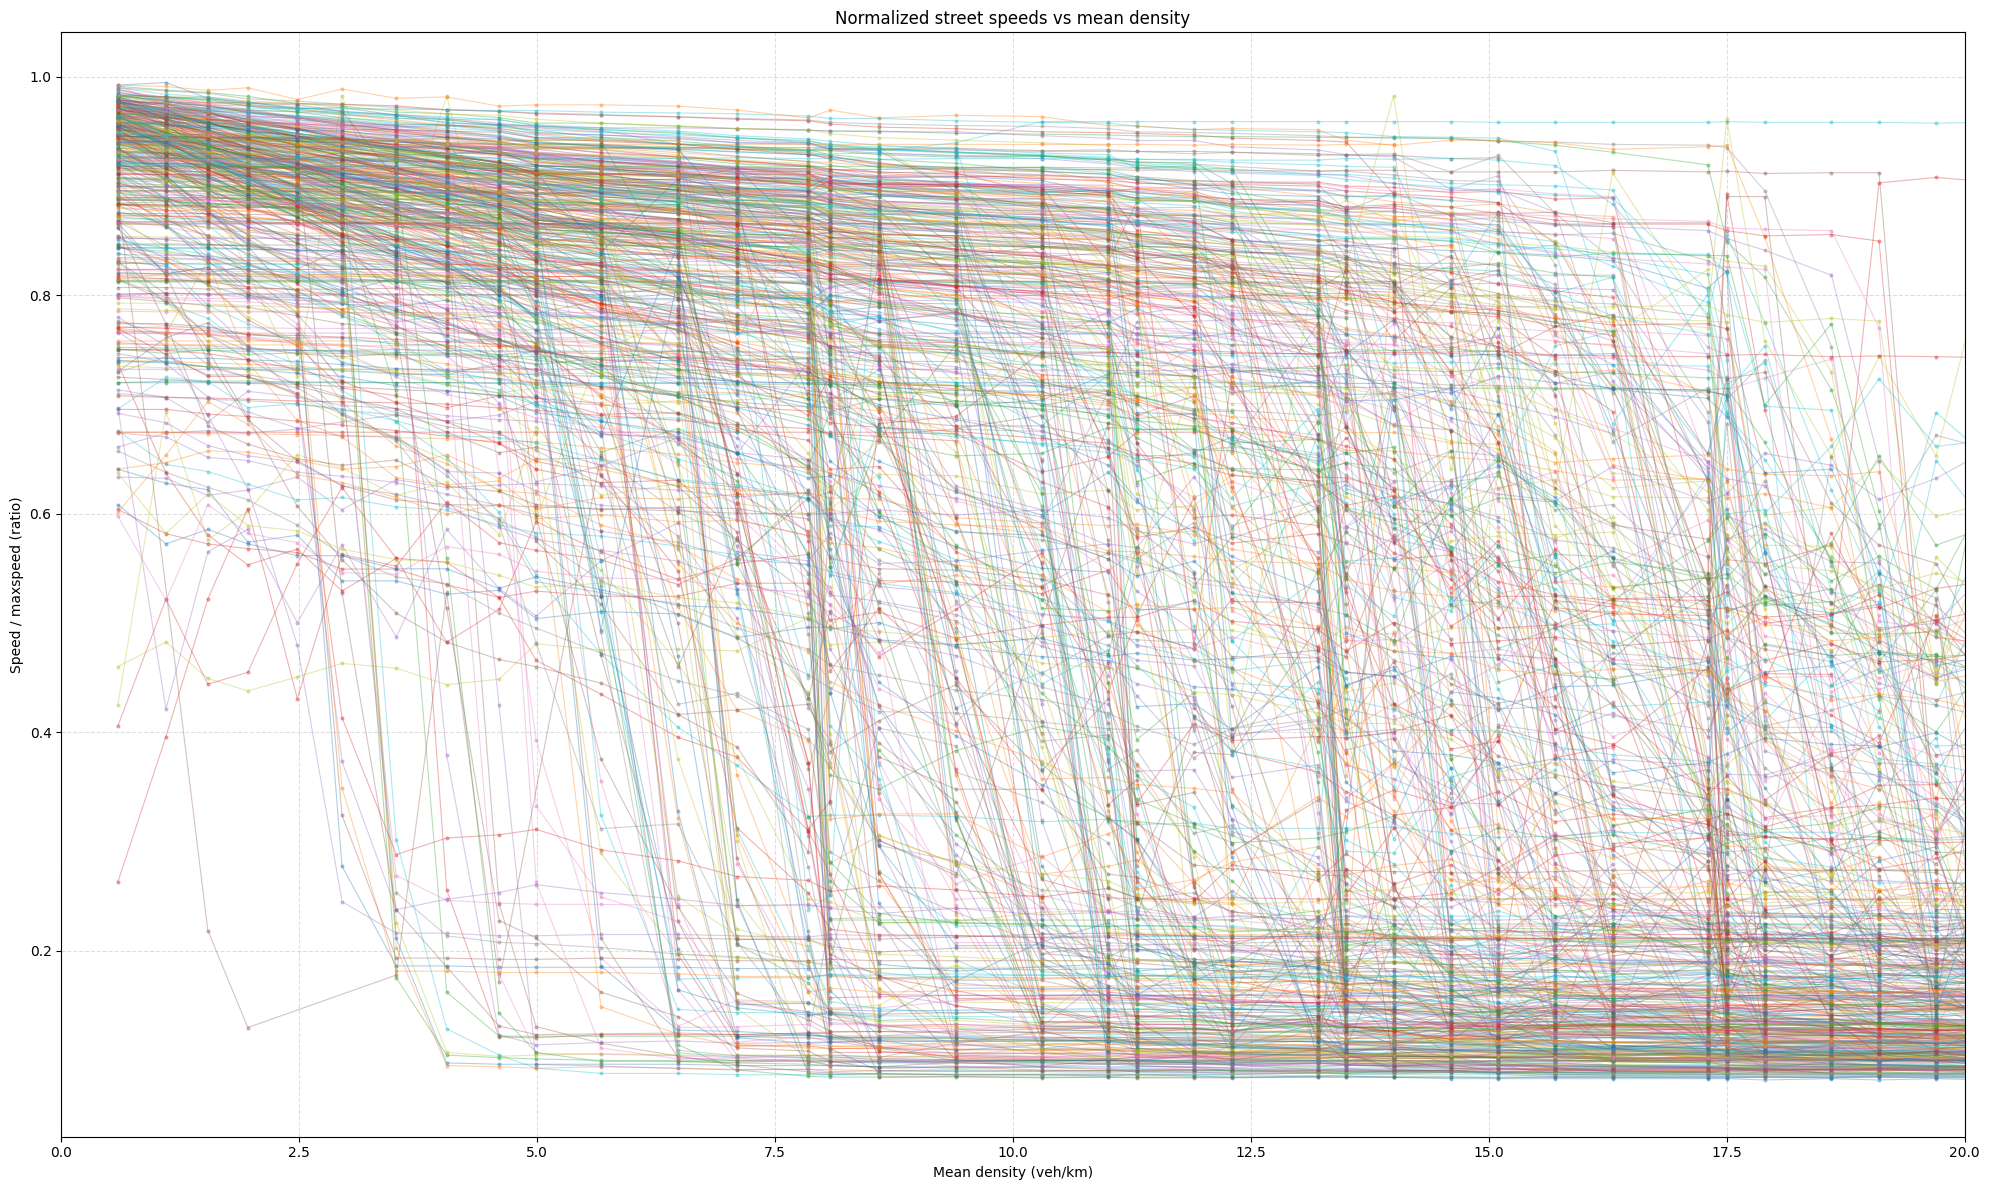

In [55]:
# Plot normalized speed ratios vs mean density for kept streets
fig, ax = plt.subplots(figsize=(20, 12))
for col in keep_streets:
    ms = maxspeed_map[col] / 3.6
    series = merged[col] / ms
    mask = series.notna() & merged["mean_density_vpk"].notna()
    if mask.sum() < 2:
        continue
    ax.plot(
        merged["mean_density_vpk"][mask],
        series[mask],
        marker="o",
        markersize=2,
        linewidth=0.8,
        alpha=0.35,
    )

ax.set_xlabel("Mean density (veh/km)")
ax.set_ylabel("Speed / maxspeed (ratio)")
ax.set_xlim(0, 20)
ax.set_title("Normalized street speeds vs mean density")
ax.grid(True, which="both", linestyle="--", alpha=0.4)
plt.savefig("../output/norm_speeds_vs_density.png", dpi=500)
plt.tight_layout()
plt.show()

In [61]:
# Classify streets by density window based on speed ratio pattern (>0.55 then <0.35 within window)
WINDOW_BAND = 2.5
DENSITY_START = 2
DENSITY_END = 10

valid_streets = []
for col in street_subset:
    ms = maxspeed_map.get(col)
    if ms is None or pd.isna(ms) or ms == 0 or col not in speed_cols:
        continue
    valid_streets.append(col)

# Build density windows
windows = []
low = DENSITY_START
high = low + WINDOW_BAND

while high <= DENSITY_END + 1e-9:
    # taglio l'ultimo intervallo a DENSITY_END se lo supera
    windows.append((low, min(high, DENSITY_END + 1e-9)))
    high += WINDOW_BAND

classes = {f"{lo:.2f}-{hi:.2f}": [] for lo, hi in windows}

for col in valid_streets:
    ms = maxspeed_map[col] / 3.6
    ratio = merged[col] / ms
    for lo, hi in windows:
        label = f"{lo:.2f}-{hi:.2f}"
        mask = (merged["mean_density_vpk"] >= lo) & (merged["mean_density_vpk"] < hi)
        vals = ratio[mask]
        if vals.empty:
            continue
        # Find first high >0.55 then any later low <0.35
        hi_idx = vals[vals > 0.55].index.min()
        if pd.isna(hi_idx):
            continue
        later = vals.loc[vals.index > hi_idx]
        if (later < 0.35).any():
            classes[label].append(col)
            break  # stop after first matching window for this street

# Drop empty classes
classes = {k: v for k, v in classes.items() if v}
print(f"Classes found: {len(classes)}")
for lbl, streets in classes.items():
    print(f"  {lbl}: {len(streets)} streets")

Classes found: 3
  2.00-4.50: 15 streets
  2.00-7.00: 33 streets
  2.00-9.50: 89 streets


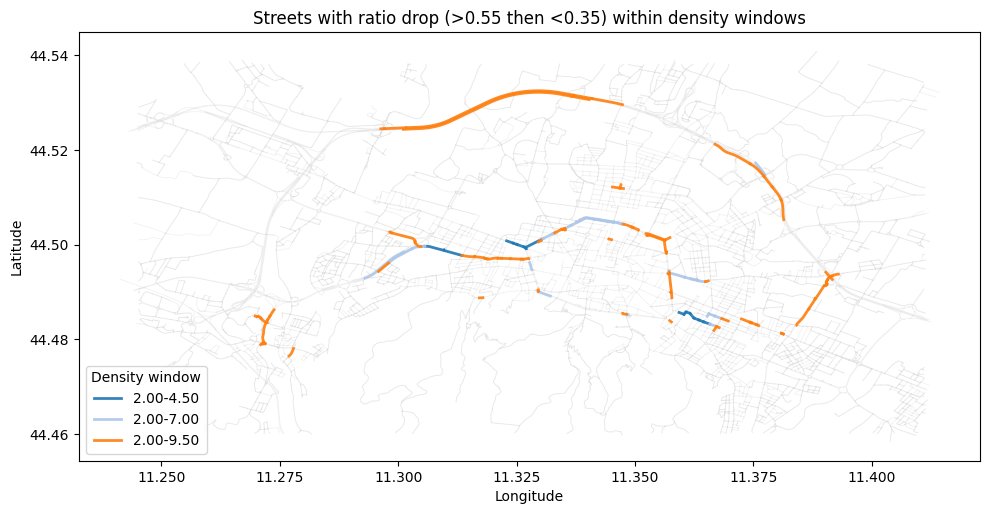

In [62]:
# Plot classes on the map with different colors
if not classes:
    print("No classes found; adjust WINDOW_BAND / thresholds.")
else:
    geom_map = edges.set_index(edges["id"].astype(str))["geometry"].to_dict()
    def parse_linestring(wkt):
        if not isinstance(wkt, str) or "LINESTRING" not in wkt:
            return None
        inner = wkt.split("(", 1)[1].rsplit(")", 1)[0]
        coords = []
        for pair in inner.split(','):
            parts = pair.strip().split()
            if len(parts) != 2:
                continue
            x, y = map(float, parts)
            coords.append((x, y))
        return coords if coords else None

    colors = plt.cm.tab20.colors
    fig, ax = plt.subplots(figsize=(10, 10))
    # base network
    for sid, geom in geom_map.items():
        coords = parse_linestring(geom)
        if not coords:
            continue
        xs, ys = zip(*coords)
        ax.plot(xs, ys, color='lightgray', linewidth=0.6, alpha=0.3)

    for idx, (label, streets) in enumerate(classes.items()):
        color = colors[idx % len(colors)]
        for sid in streets:
            geom = geom_map.get(str(sid))
            coords = parse_linestring(geom)
            if not coords:
                continue
            xs, ys = zip(*coords)
            ax.plot(xs, ys, color=color, linewidth=2.0, alpha=0.9, label=label if idx == list(classes.keys()).index(label) else None)

    handles, labels = ax.get_legend_handles_labels()
    unique = dict(zip(labels, handles))
    if unique:
        ax.legend(unique.values(), unique.keys(), title="Density window")
    ax.set_title('Streets with ratio drop (>0.55 then <0.35) within density windows')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_aspect('equal')
    plt.tight_layout()
    plt.show()

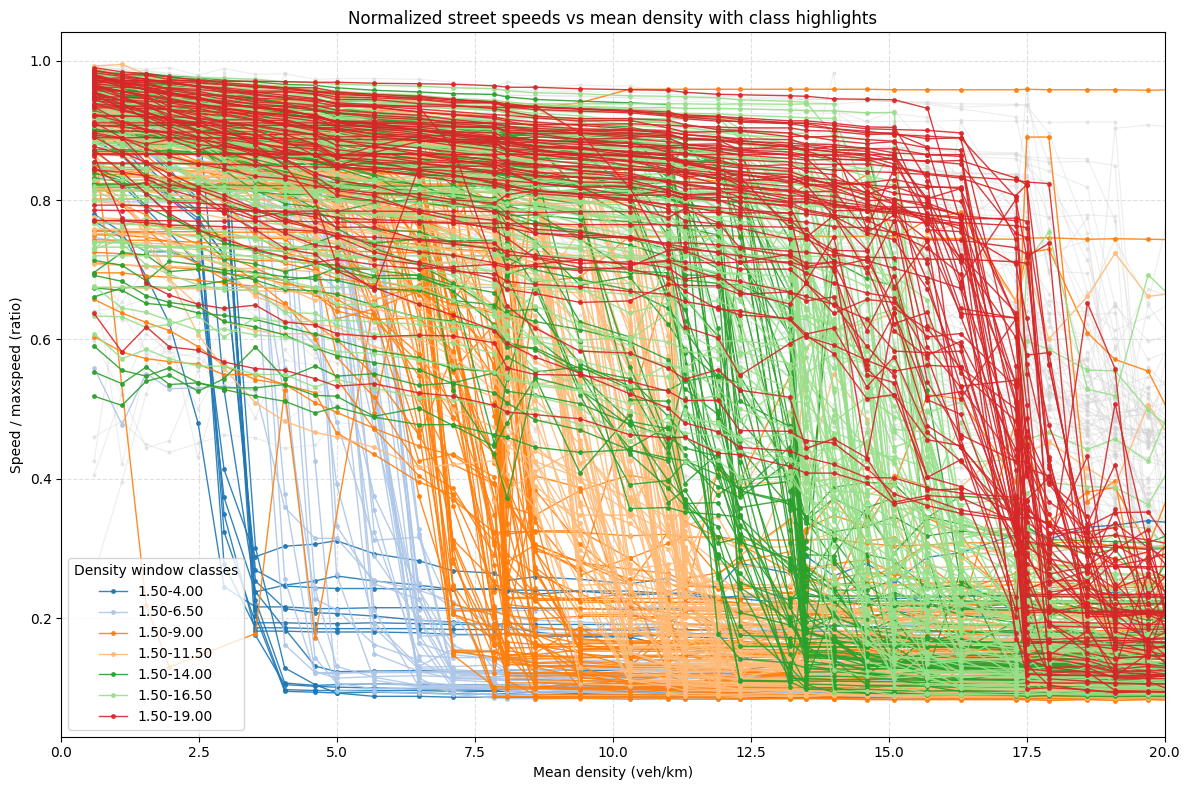

In [58]:
# Plot normalized speed ratios with class highlights
if 'classes' not in globals() or not classes:
    print("No classes available; run the classification cell or adjust thresholds.")
else:
    class_streets = {s for streets in classes.values() for s in streets}
    colors = plt.cm.tab20.colors

    fig, ax = plt.subplots(figsize=(12, 8))
    # Plot generic (non-class) streets in gray
    for col in keep_streets:
        if col in class_streets:
            continue
        ms = maxspeed_map.get(col) / 3.6
        if ms is None or pd.isna(ms) or ms == 0:
            continue
        series = merged[col] / ms
        mask = series.notna() & merged["mean_density_vpk"].notna()
        if mask.sum() < 2:
            continue
        ax.plot(
            merged["mean_density_vpk"][mask],
            series[mask],
            color='lightgray',
            marker='o',
            markersize=2,
            linewidth=0.8,
            alpha=0.4,
        )

    # Plot class streets with distinct colors
    for idx, (label, streets) in enumerate(classes.items()):
        color = colors[idx % len(colors)]
        for col in streets:
            ms = maxspeed_map.get(col) / 3.6
            if ms is None or pd.isna(ms) or ms == 0:
                continue
            series = merged[col] / ms
            mask = series.notna() & merged["mean_density_vpk"].notna()
            if mask.sum() < 2:
                continue
            ax.plot(
                merged["mean_density_vpk"][mask],
                series[mask],
                color=color,
                marker='o',
                markersize=2.5,
                linewidth=1.0,
                alpha=0.9,
                label=label,
            )

    handles, labels = ax.get_legend_handles_labels()
    unique = dict(zip(labels, handles))
    if unique:
        ax.legend(unique.values(), unique.keys(), title="Density window classes")

    ax.set_xlabel("Mean density (veh/km)")
    ax.set_ylabel("Speed / maxspeed (ratio)")
    ax.set_xlim(0, 20)
    ax.set_title("Normalized street speeds vs mean density with class highlights")
    ax.grid(True, which="both", linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()